Import the necessary libraries.

In [1]:
import csv
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer
from create_input_lists import create_input_lists_from_csv, lemmatize
from statistics import mean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from statistics import mean, median, mode
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
from sklearn.metrics import silhouette_score

Obtain and pre-process the texts.

In [2]:
paragraph_path = './OneDrive-2020-12-04/intro_bio (with periods)_labelled/paragraphs.csv'
assessment_path = './OneDrive-2020-12-04/intro_bio (with periods)_labelled/assessments.csv'

In [3]:
para_ids, lemm_para, orig_para, assess_ids, lemma_assess, orig_assess = create_input_lists_from_csv(paragraph_path, assessment_path)

Obtain the lengths of all assessments and paragraphs.

In [4]:
assessment_lengths = []
for assessment in lemma_assess:
    assessment_lengths.append(len(assessment))
    
paragraph_lengths = []
for paragraph in lemm_para:
    paragraph_lengths.append(len(paragraph))

Obtain the TF-IDF vectorization of the texts.

In [5]:
min_assessment_length = min(assessment_lengths)
max_assessment_length = max(assessment_lengths)
mean_assessment_length = 0 if len(assessment_lengths) == 0 else sum(assessment_lengths)/len(assessment_lengths)

print('Minimum Length of an Assessment:', min_assessment_length)
print('Maximum Length of an Assessment:', max_assessment_length)
print(f'Mean Length of an Assessment: {(mean_assessment_length):.2f}\n')

min_paragraph_length = min(paragraph_lengths)
max_paragraph_length = max(paragraph_lengths)
mean_paragraph_length = 0 if len(paragraph_lengths) == 0 else sum(paragraph_lengths)/len(paragraph_lengths)

print('Minimum Length of a Paragraph:', min_paragraph_length)
print('Maximum Length of a Paragraph:', max_paragraph_length)
print(f'Mean Length of a Paragraph: {(mean_paragraph_length):.2f}')

Minimum Length of an Assessment: 9
Maximum Length of an Assessment: 921
Mean Length of an Assessment: 161.67

Minimum Length of a Paragraph: 1
Maximum Length of a Paragraph: 2150
Mean Length of a Paragraph: 213.39


Obtain the TF-IDF vectorization of the texts.

In [6]:
vectorizer = TfidfVectorizer(use_idf=True, stop_words = 'english')
para_vectors = vectorizer.fit_transform(lemm_para)
assess_vectors = vectorizer.fit_transform(lemma_assess)

In [7]:
print(para_vectors.shape)
print(assess_vectors.shape)

(1608, 4121)
(1095, 2630)


In [8]:
para_nonzero_counts = []
for vector in para_vectors:
    para_nonzero_counts.append(vector.count_nonzero())

assess_nonzero_counts = []
for vector in assess_vectors:
    assess_nonzero_counts.append(vector.count_nonzero())

Output Summary Statistics of Vectorizations:

In [9]:
print('TF-IDF for Paragraphs:\n')
print('Average Number of Non-Zeros:', mean(para_nonzero_counts))
print('Total # of Dimensions:', para_vectors.shape[1])


print('\n\nTF-IDF for Assessments:\n')
print('Average Number of Non-Zeros:', mean(assess_nonzero_counts))
print('Total # of Dimensions:', assess_vectors.shape[1])

TF-IDF for Paragraphs:

Average Number of Non-Zeros: 20.018034825870647
Total # of Dimensions: 4121


TF-IDF for Assessments:

Average Number of Non-Zeros: 14.107762557077626
Total # of Dimensions: 2630


In [10]:
def plot_distances(distances_list):
    plt.hist(distances_list, rwidth = 0.8, bins=np.arange(min(distances_list), max(distances_list) + 0.01, 0.01))
    plt.xlabel('Pairwise Distance',fontsize=10)
    plt.ylabel('Frequency',fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.xticks(np.arange(min(distances_list), max(distances_list)+0.1, 0.1))
    plt.grid()
    plt.show()
    
def plot_similarities(cos_sim_list):
    plt.hist(cos_sim_list, rwidth = 0.8, bins=np.arange(min(cos_sim_list), max(cos_sim_list) + 0.01, 0.01))
    plt.xlabel('Pairwise Cosine Similarity',fontsize=10)
    plt.ylabel('Frequency',fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.xticks(np.arange(min(cos_sim_list), max(cos_sim_list)+0.1, 0.1))
    plt.grid()
    plt.show()
    
def calculate_pairwise_metrics(pairs):    
    cos_sim_list = []
    dist_list = []
    orthogonal_count = 0
    for pair in pairs:
        a,b = pair
        a = np.array(a)
        b = np.array(b)
        cos_sim = dot(a, b)/(norm(a)*norm(b))
        cos_sim_list.append(cos_sim)

        if cos_sim == 0:
            orthogonal_count += 1

        dist = norm(a - b)
        dist_list.append(dist)
    
    return(cos_sim_list, orthogonal_count, dist_list)

def print_similarity_statistics(sim_list):
    sim_list = [x for x in sim_list if math.isnan(x) == False]
    print('Cosine Similarity Mean:', mean(sim_list))
    print('Cosine Similarity Median:', median(sim_list))
    print('Cosine Similarity Mode:', mode(sim_list))
    print('Cosine Similarity Min:', min(sim_list))
    print('Cosine Similarity Max:', max(sim_list))
    
def print_distance_statistics(dist_list):
    dist_list = [x for x in dist_list if math.isnan(x) == False]
    print('Euclidean Distance Mean:', mean(dist_list))
    print('Euclidean Distance Median:', median(dist_list))
    print('Euclidean Distance Mode:', mode(dist_list))
    print('Euclidean Distance Min:', min(dist_list))
    print('Euclidean Distance Max:', max(dist_list))

In [11]:
k = 2
k_list = []
best_k_silhouette = 2
best_k_ssd = 2

s_list = []
ssd_list = []

best_s = 0.0
best_ssd = np.inf

while k <= 800:
    km = KMeans(n_clusters = k, max_iter = 50000, init = 'k-means++', random_state=43)
    cluster_assignment = km.fit(assess_vectors).labels_
    s = silhouette_score(assess_vectors, cluster_assignment, metric='euclidean')
    ssd = km.inertia_
    if s > best_s:
        best_s = s
        best_k_silhouette = k
    if ssd < best_ssd:
        best_ssd = ssd
        best_k_ssd = k
    k_list.append(k)
    s_list.append(s)
    ssd_list.append(ssd)
    k += 1

Best value for k (Silhouette): 575
Best Silhouette Score: 0.1477311515880876


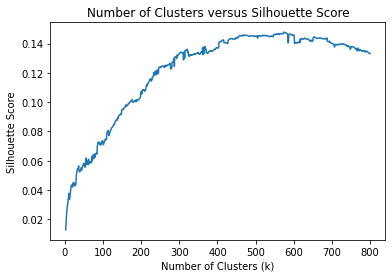

In [16]:
plt.plot(k_list,s_list)
plt.title('Number of Clusters versus Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.savefig('silhouette_curve_optimal_k_bio.pdf')
plt.close

print('Best value for k (Silhouette):', best_k_silhouette)
print('Best Silhouette Score:', best_s)

Best value for k (SSD): 800
Best Sum of Squared Distances: 80.0671068526285


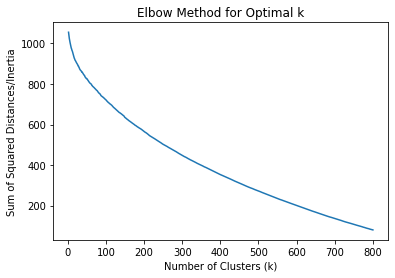

In [17]:
plt.plot(k_list,ssd_list)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances/Inertia')
plt.savefig('ssd_curve_optimal_k_bio.pdf')
plt.close

print('Best value for k (SSD):', best_k_ssd)
print('Best Sum of Squared Distances:', best_ssd)